<a href="https://colab.research.google.com/github/HofstraDoboli/TextMining_F22/blob/main/movie_clustering_agglomerative.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
import os
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn import metrics


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/TextMining_F22
%ls *.csv

/content/drive/MyDrive/TextMining_F22
wiki_movie_plots_deduped.csv


In [4]:
dir_file = os.getcwd() # returns path to current directory
files_dir = os.listdir(dir_file)  # list of files in current directory

csv_files = [f for f in files_dir if f.endswith('csv')]
print(csv_files)
movie_file = csv_files[0]

movie_df = pd.read_csv(movie_file)
print(movie_df.columns)  # the columns
print(movie_df.shape)

['wiki_movie_plots_deduped.csv']
Index(['Release Year', 'Title', 'Origin/Ethnicity', 'Director', 'Cast',
       'Genre', 'Wiki Page', 'Plot'],
      dtype='object')
(34886, 8)


In [5]:
# genres
movie_df.Genre[movie_df.Genre == 'sci-fi'].value_counts()

sci-fi    221
Name: Genre, dtype: int64

In [6]:
choose_genres = ['western', 'thriller', 'sci-fi']
select_movies = movie_df[['Title', 'Plot', 'Genre']][movie_df['Genre'].isin(choose_genres)]
select_movies.head()

,Title,Plot,Genre
6,The Great Train Robbery,The film opens with two bandits breaking into ...,western
21,The Fight for Freedom,The film opens in a town on the Mexican border...,western
97,Rose of the Rancho,Esra Kincaid (La Reno) takes land by force and...,western
99,Salomy Jane,Rough-and-tumble Gold Rush-era California: a w...,western
101,The Squaw Man,James Wynnegate (Dustin Farnum) and his cousin...,western


In [ ]:
select_movies['Title'][select_movies['Title'].str.contains('Star Wars')]

16378    Star Wars: Episode I – The Phantom Menace 3D
17159             Rogue One: A Star Wars Story (film)
Name: Title, dtype: object

In [ ]:
select_movies['Title'][select_movies['Title'].str.contains('Star Trek')]

11726    Star Trek VI: The Undiscovered Country
Name: Title, dtype: object

In [7]:
import numpy as np
import spacy   # another tokenizer, lemmatizer (has --> be)
nlp = spacy.load('en_core_web_sm')
nlp.disable_pipes('parser', 'ner')

['parser', 'ner']

In [8]:
def nlp_processing(doc): # from indexing.ipyns
    tokens = nlp(doc)

    #print(type(tokens))
    # eliminates stop words  and non alpha num and converts all to lower case
    terms = [token.lemma_.lower() for token in tokens if not token.is_stop and token.is_alpha]

    return terms

vect = CountVectorizer(tokenizer = nlp_processing, min_df = 10) # ? why 50

counter = vect.fit_transform(select_movies['Plot'])
 # matrix representation of each movie as a tf-idf vector
print(len(vect.get_feature_names_out()))

print(vect.get_feature_names_out()[:100])
print(vect.get_feature_names_out()[-20:])

print(counter.shape)
tf_all = counter.sum(axis = 0)
print(tf_all.shape)
ind_terms_sorted = tf_all.argsort()
print(ind_terms_sorted.shape)
print(tf_all[0,ind_terms_sorted[0,0:20]])
print(tf_all[0,ind_terms_sorted[0,-20:]])
print('rarest', vect.get_feature_names_out()[ind_terms_sorted[0,:20]])
print('most common', vect.get_feature_names_out()[ind_terms_sorted[0,-20:]])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


3928
['abandon' 'abduct' 'abduction' 'abductor' 'ability' 'able' 'aboard'
 'abort' 'abraham' 'abruptly' 'absence' 'absorb' 'abuse' 'abusive'
 'accept' 'access' 'accident' 'accidental' 'accidentally' 'accompany'
 'accomplice' 'accomplish' 'accord' 'accost' 'account' 'accusation'
 'accuse' 'ace' 'achieve' 'acid' 'acknowledge' 'acquaint' 'acquaintance'
 'acquire' 'acquit' 'act' 'action' 'activate' 'active' 'activity' 'actor'
 'actress' 'actual' 'actually' 'adam' 'add' 'addict' 'addition'
 'additional' 'address' 'adjacent' 'administer' 'admire' 'admit' 'adopt'
 'adoptive' 'adult' 'advance' 'advanced' 'advantage' 'adventure' 'advice'
 'advise' 'aerial' 'affair' 'affect' 'affection' 'afford' 'afraid'
 'africa' 'african' 'aftermath' 'afternoon' 'afterward' 'age' 'aged'
 'agency' 'agent' 'aggressive' 'ago' 'agree' 'agreement' 'ahead' 'aid'
 'aide' 'ail' 'aim' 'air' 'aircraft' 'airline' 'airport' 'ajay' 'aka' 'al'
 'alan' 'alarm' 'albert' 'alcohol' 'alcoholic' 'alert']
['write' 'writer' 'wrong'

In [9]:
transf  = TfidfTransformer(norm = 'l2', sublinear_tf = True)
# TfidfTransformer takes the CountVectorizer output and computes the tf-idf
tf_idf = transf.fit_transform(counter)

In [ ]:
from sklearn.metrics import pairwise_distances
print(np.mean(pairwise_distances(tf_idf, metric = 'l2')))
print(np.max(pairwise_distances(tf_idf)))
print(np.min(pairwise_distances(tf_idf)))


1.3795946772743812
1.4142135623730958
0.0


## Agglomerative clustering

### TF-IDF space over 3k dimensions

1. complete linkage
* Eulidean
* Cosine
2. average linkage
* Eulidean
* Cosine
3. Ward linkage (increase in sum of square errors (SSE) by merging two clusters)
   D(Ci, Cj) = SSE(Ci,Cj) - (SSE(Ci) + SSE(Cj))
* Eulidean





In [10]:
k_clusters = 5 #None # 10
from matplotlib import pyplot as plt
# “euclidean”, “l1”, “l2”, “manhattan”, “cosine”,
# linkage{‘ward’, ‘complete’, ‘average’, ‘single’}, default=’ward’
# 'ward' works only with 'euclidean'
# distance_threshold = 0 computes the full tree
agglom = AgglomerativeClustering(n_clusters = 5, affinity='euclidean', linkage ='ward',
                                distance_threshold = None, compute_distances = True)
tf_idf_array = tf_idf.toarray()
agglom_tf_idf = agglom.fit(tf_idf_array)
print(agglom_tf_idf.n_clusters_)
print("\nSilhouette Coefficient: %0.3f" %metrics.silhouette_score(tf_idf, agglom_tf_idf.labels_, metric = "cosine"))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


5

Silhouette Coefficient: 0.000


In [11]:
from collections import Counter
model = agglom # agglom_use # agglom_lsi # agglom_tfidf
# compute purity
# in each cluster - find # of dramas/ # commedies
# choose the max in each cluster = purity per cluster
# sum purity in each cluster/# number of movies
import numpy as np
genre = pd.Categorical(select_movies.Genre)
#print(genre.shape, index_cluster1.shape, index_cluster2.shape)
k_clusters = model.n_clusters_
purity = np.zeros((k_clusters,1))
for c in range(k_clusters):
    # extract labeks of each genre and count them
    index_cluster = model.labels_ == c;
    count_genre = Counter(genre[index_cluster])
    print(c, count_genre)
    purity[c] = max(count_genre.values())

total_purity = np.sum(purity)/len(genre)
print(total_purity)

0 Counter({'western': 516, 'thriller': 77, 'sci-fi': 9})
1 Counter({'thriller': 577, 'western': 137, 'sci-fi': 38})
2 Counter({'sci-fi': 152, 'thriller': 42, 'western': 2})
3 Counter({'western': 194, 'thriller': 5, 'sci-fi': 1})
4 Counter({'thriller': 265, 'sci-fi': 21, 'western': 16})
0.8304093567251462


In [16]:
# compute the centroids of the agglomerative clusters
centroids_agglom = np.zeros((k_clusters, tf_idf_array.shape[1]))
for c in range(k_clusters):
  ind_mov = np.where(agglom.labels_ == c)[0]
  centroids_agglom[c,:] = np.mean(tf_idf_array[ind_mov,:], axis = 0)

print(centroids_agglom[:,:10])

[[0.00340619 0.00203821 0.00011595 0.00022598 0.00031343 0.00543636
  0.00053154 0.0002121  0.00017605 0.00091647]
 [0.00227814 0.00273145 0.0003944  0.00076183 0.00218898 0.00663187
  0.00251167 0.00067443 0.00057741 0.00034495]
 [0.00887231 0.00069226 0.0004378  0.00034064 0.00948612 0.01241825
  0.01266673 0.00163484 0.00049755 0.00108475]
 [0.00407575 0.0015717  0.00043447 0.         0.00035673 0.00334448
  0.00036728 0.         0.00242963 0.00050017]
 [0.00767031 0.00456271 0.00312296 0.00116106 0.00256986 0.00848842
  0.00045006 0.00105535 0.00028744 0.00204122]]


In [ ]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)



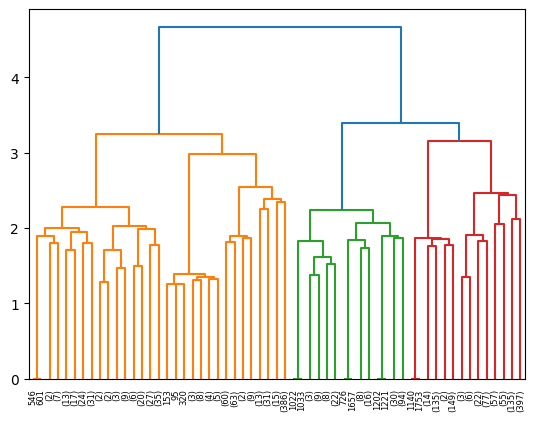

In [ ]:
model = agglom # agglom_lda # agglom_lsi # agglom_model
plot_dendrogram(model, truncate_mode="level", p=5)

In [ ]:
# use sentence embeddings - USE
import tensorflow as tf
import tensorflow_hub as hub

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model_use = hub.load(module_url)
print ("module %s loaded" % module_url)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [ ]:
# embed the movie plots using use
use_embed = model_use(select_movies['Plot'])

In [ ]:
use_embed.shape

TensorShape([2052, 512])

In [ ]:
# Don't use using default text processing in CountVectorizer
vect1 = CountVectorizer(stop_words = "english", lowercase = True, min_df = 100)
counter1 = vect1.fit_transform(select_movies['Plot'])
print(len(vect1.get_feature_names_out()))

print(vect1.get_feature_names_out()[:100])
print(vect1.get_feature_names_out()[-20:])

402
['000' 'able' 'accident' 'accidentally' 'actually' 'affair' 'agent'
 'agrees' 'alive' 'american' 'apartment' 'appears' 'army' 'arrest'
 'arrested' 'arrive' 'arrives' 'asks' 'attack' 'attacked' 'attacks'
 'attempt' 'attempts' 'away' 'bank' 'battle' 'begin' 'begins' 'believe'
 'believes' 'best' 'blood' 'body' 'boss' 'boy' 'break' 'breaks' 'bring'
 'brings' 'brother' 'building' 'business' 'called' 'calls' 'captain'
 'captured' 'car' 'case' 'cattle' 'caught' 'causing' 'chief' 'child'
 'children' 'city' 'claims' 'clear' 'come' 'comes' 'coming' 'company'
 'confronts' 'continue' 'continues' 'control' 'convinces' 'couple' 'crime'
 'daughter' 'day' 'days' 'dead' 'death' 'decide' 'decides' 'demands'
 'despite' 'detective' 'did' 'die' 'died' 'dies' 'discover' 'discovered'
 'discovers' 'doctor' 'does' 'doesn' 'door' 'dr' 'drive' 'earlier' 'end'
 'ends' 'enters' 'escape' 'escapes' 'eventually' 'evidence' 'ex']
['warns' 'watch' 'water' 'way' 'wealthy' 'west' 'white' 'wife' 'window'
 'woman' 'wom

In [ ]:
k_clusters = 3
from matplotlib import pyplot as plt
# “euclidean”, “l1”, “l2”, “manhattan”, “cosine”,
# linkage{‘ward’, ‘complete’, ‘average’, ‘single’}, default=’ward’
# 'ward' works only with 'euclidean'
# distance_threshold = 0 computes the full tree
agglom = AgglomerativeClustering(n_clusters = k_clusters, affinity='euclidean', linkage = 'ward',
                                distance_threshold = None)
agglom_tfidf = agglom.fit(tf_idf.toarray())
print(agglom_tfidf.n_clusters_)
print("\nSilhouette Coefficient: %0.3f" %metrics.silhouette_score(tf_idf, agglom_tfidf.labels_, metric = "cosine"))

3

Silhouette Coefficient: 0.006


In [ ]:
# SVD dimensionality reduction
# project Tfidf model onto singular value decomposition - LSI transform and then do clustering
from sklearn.decomposition import TruncatedSVD

dim = 1000 # 1300 dimensions explain 95% variance
svd = TruncatedSVD(n_components=dim, n_iter = 10)

lsi = svd.fit_transform(tf_idf)
explained_variance = svd.explained_variance_ratio_.sum()
print("Sum of explained variance ratio: %d%%" % (int(explained_variance * 100)))

Sum of explained variance ratio: 84%


In [ ]:
# LDA with sklearn
from sklearn.decomposition import LatentDirichletAllocation

num_of_topics = 200 # more topics, better to separate the clusters.
lda_transf = LatentDirichletAllocation(
            n_components = num_of_topics, max_iter= 10,
            learning_method = 'online', batch_size = 128)   # 'online' - faster, uses subset of data
lda = lda_transf.fit_transform(counter)
print(lda.shape)
print(lda_transf.components_.shape)

(2052, 200)
(200, 3921)


In [ ]:
k_clusters = 3 # None # 10 #None # 10
from matplotlib import pyplot as plt
# “euclidean”, “l1”, “l2”, “manhattan”, “cosine”,
# linkage{‘ward’, ‘complete’, ‘average’, ‘single’}, default=’ward’
# 'ward' works only with 'euclidean'
# distance_threshold = 0 computes the full tree
agglom = AgglomerativeClustering(n_clusters = k_clusters, affinity='euclidean', linkage = 'ward',
                                distance_threshold = None)
agglom_lda = agglom.fit(lda)
print(agglom_lda.n_clusters_)
print("\nSilhouette Coefficient: %0.3f" %metrics.silhouette_score(lda, agglom_lda.labels_, metric = "cosine"))

3

Silhouette Coefficient: 0.369


In [ ]:
# use USE embeddings
k_clusters = 3 # 10
from matplotlib import pyplot as plt
# “euclidean”, “l1”, “l2”, “manhattan”, “cosine”,
# linkage{‘ward’, ‘complete’, ‘average’, ‘single’}, default=’ward’
# 'ward' works only with 'euclidean'
# distance_threshold = 0 computes the full tree
agglom = AgglomerativeClustering(n_clusters = k_clusters, affinity='euclidean', linkage = 'ward',
                                distance_threshold = None)
agglom_use = agglom.fit(use_embed)
print(agglom_use.n_clusters_)
print("\nSilhouette Coefficient: %0.3f" %metrics.silhouette_score(use_embed, agglom_use.labels_, metric = "cosine"))

3

Silhouette Coefficient: 0.039


In [ ]:
# print top topic indices per cluster
print("Top top words per cluster:")
terms = vect.get_feature_names_out()

model = agglom_lda # agglom_lsi # agglom_tfidf
# TO DO: order terms in a cluster by tf-idf not just tf
# find movies in each cluster, sum up their counts and print the top words
for k in range(model.n_clusters_):
    index_movies_k = model.labels_ == k
    count_terms_k = sum(counter[index_movies_k,:])   # sum per columns (overall frequency)
    order_terms = count_terms_k.toarray().argsort()[:,::-1].ravel()  # convert to a 1D array
    print('Cluster', k)

    for t in order_terms[:10]:
        print('\t', terms[t], count_terms_k[0,t])


Top top words per cluster:
Cluster 0
	 kill 336
	 find 265
	 dr 196
	 man 189
	 force 179
	 earth 170
	 escape 164
	 leave 164
	 take 161
	 alien 159
Cluster 1
	 kill 815
	 find 681
	 man 566
	 tell 540
	 leave 513
	 go 399
	 take 399
	 murder 379
	 police 367
	 try 358
Cluster 2
	 kill 280
	 man 196
	 find 186
	 father 174
	 jack 171
	 money 167
	 murder 158
	 take 140
	 leave 132
	 shoot 129
Cluster 3
	 man 78
	 custer 75
	 fort 71
	 kill 58
	 gene 56
	 apache 56
	 war 53
	 lead 48
	 cavalry 46
	 command 46
Cluster 4
	 man 293
	 kill 224
	 gold 154
	 train 147
	 wagon 122
	 attack 121
	 leave 118
	 town 116
	 war 116
	 shoot 108
Cluster 5
	 find 401
	 tell 383
	 leave 325
	 kill 297
	 man 287
	 go 274
	 car 246
	 house 225
	 try 213
	 say 203
Cluster 6
	 kill 296
	 find 252
	 police 208
	 murder 205
	 take 174
	 tell 148
	 leave 140
	 man 137
	 escape 126
	 reveal 126
Cluster 7
	 man 360
	 kill 312
	 town 244
	 ranch 191
	 shoot 166
	 gene 161
	 gang 148
	 leave 145
	 father 141
	 re

In [ ]:
# compute homogeneity with genre labels
model = agglom_use # agglom_lda # agglom_lsi # agglom_tfidf
# get genre for the selected movies
genre = pd.Categorical(select_movies.Genre)

print("Homogeneity: %0.3f"  % metrics.homogeneity_score(genre, model.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(genre, model.labels_))
print("V-measure: %0.3f"    % metrics.v_measure_score(genre, model.labels_))
print("Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(genre, model.labels_))

Homogeneity: 0.591
Completeness: 0.170
V-measure: 0.264
Adjusted Rand-Index: 0.075


In [ ]:
# plot clusters
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.decomposition import TruncatedSVD
pca = TruncatedSVD(n_components = 2)
#print('explained variance')
pca.fit(tf_idf)
x2 = pca.transform(tf_idf)

In [ ]:
print(x2.shape)
# add labels
model = agglom_lsi # agglom_use # agglom_lda # agglom_lsi # agglom_tfidf
data_x2 = pd.DataFrame(x2, columns = ['x','y'])
data_x2['label'] = model.labels_
data_x2['orig_label'] = genre
data_x2.head()

(2052, 2)


,x,y,label,orig_label
0,0.194878,0.045397,0,western
1,0.229486,0.156645,6,western
2,0.109479,0.037830,0,western
3,0.075191,0.039589,3,western
4,0.222659,0.047510,4,western


/usr/local/lib/python3.7/dist-packages/seaborn/regression.py:592: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


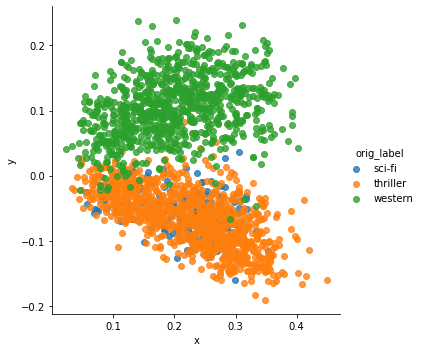

In [ ]:
sb.lmplot(data=data_x2, x='x', y='y', hue='orig_label',fit_reg=False, legend=True, legend_out=True)

/usr/local/lib/python3.7/dist-packages/seaborn/regression.py:592: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


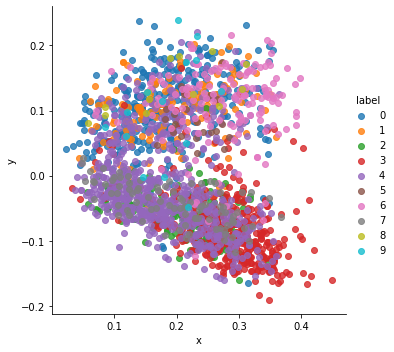

In [ ]:
sb.lmplot(data=data_x2, x='x', y='y', hue='label',fit_reg=False, legend=True, legend_out=True)

In [ ]:
# get largest distribution of words over topics
feature_names = vect.get_feature_names()  # feature_names - array of 8955 components
for topic_idx, topic in enumerate(lda_transf.components_):
        print("Topic %d:" % (topic_idx))
        words = []
        for i in topic.argsort()[:-11:-1]:
            words.append(feature_names[i])
        print(words)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Topic 0:
['pete', 'scott', 'kansas', 'finger', 'dawson', 'bust', 'heated', 'proof', 'wayne', 'feel']
Topic 1:
['anticipate', 'precious', 'tombstone', 'chat', 'investment', 'en', 'cahoot', 'treatment', 'carefully', 'giant']
Topic 2:
['handle', 'angeles', 'japanese', 'nanny', 'angel', 'remainder', 'permission', 'kirby', 'slap', 'unlike']
Topic 3:
['utah', 'tex', 'disguise', 'journey', 'butcher', 'florida', 'jealous', 'threat', 'friendship', 'lake']
Topic 4:
['father', 'wish', 'old', 'mexico', 'story', 'mask', 'send', 'place', 'love', 'take']
Topic 5:
['de', 'mexican', 'carlos', 'la', 'warner', 'jose', 'california', 'criminal', 'farmer', 'americans']
Topic 6:
['truck', 'connie', 'diner', 'vehicle', 'lane', 'drive', 'gas', 'station', 'janice', 'jeep']
Topic 7:
['singe', 'common', 'young', 'illness', 'perfect', 'local', 'teacher', 'seemingly', 'bury', 'andrews']
Topic 8:
['nick', 'lisa', 'beth', 'roman', 'farrell', 'derek', 'juan', 'knock', 'domestic', 'accompany']
Topic 9:
['roy', 'far', '

In [ ]:
# get distribution of each document over the 10 topics
print(lda[100,:])
print(select_movies.iloc[100].Plot)
print(model_lda.labels_[100])

[3.96825397e-04 3.96825397e-04 3.96825400e-04 3.96825407e-04
 3.96825397e-04 1.82212823e-02 5.60165542e-01 3.96825403e-04
 3.96825402e-04 3.96825397e-04 3.96825403e-04 3.96825399e-04
 3.96825405e-04 3.96825408e-04 1.10543913e-01 3.96825406e-04
 3.96825406e-04 3.96825397e-04 3.96825398e-04 3.04720057e-01]
In Red River Valley, Banker Hartley Moore (Frank LaRue) schemes to sabotage the efforts of citizens to secure water rights in order to win water profits for himself. Following the murder of five men who were overseeing the completion of an irrigation system, Gene Autry (Gene Autry) is hired for the dangerous job of "ditch rider", in charge of patrolling the ditches to prevent malfunction or sabotage.
At the Red River Land and Irrigation Company, Steve Conway (Boothe Howard) works for Mary Baxter (Frances Grant) and her father, George Baxter (Sam Flint). Jealous of Mary's attention towards Gene, Conway joins Moore in his scheming actions and hires Bull Dural and his gang to dynamite the

In [ ]:
# get distribution of drama and comedy films over topics
import numpy as np

index_western =  select_movies['Genre'].isin(['western'])
index_thriller  = select_movies['Genre'].isin(['thriller'])
index_sci_fi  = select_movies['Genre'].isin(['sci-fi'])

print(lda[index_western].mean(axis = 0))
print(lda[index_thriller].mean(axis = 0))
print(lda[index_sci_fi].mean(axis = 0))

[0.00507928 0.27857604 0.00763062 0.12786623 0.00762866 0.01803683
 0.02688263 0.0334441  0.24527927 0.24957636]
[0.00620445 0.03241247 0.00858699 0.01678065 0.00509486 0.05094989
 0.39208954 0.10557791 0.22174247 0.16056076]
[0.00892725 0.02085182 0.00402227 0.01742414 0.00204825 0.38262526
 0.25620151 0.05969024 0.17538024 0.07282903]


In [ ]:
# compute purity
# in each cluster - find # of dramas/ # commedies
# choose the max in each cluster = purity per cluster
# sum purity in each cluster/# number of movies
import numpy as np

#print(genre.shape, index_cluster1.shape, index_cluster2.shape)
purity = np.zeros((k_clusters,1))
for c in range(k_clusters):
    # extract labeks of each genre and count them
    index_cluster = model_lda.labels_ == c;
    count_genre = Counter(genre[index_cluster])
    print(c, count_genre)
    purity[c] = max(count_genre.values())

total_purity = np.sum(purity)/len(genre)
print(total_purity)

0 Counter({'western': 843, 'thriller': 390})
1 Counter({'thriller': 576, 'western': 22})
0.774986346258875


In [ ]:
# print top topic indices per cluster
print("Top topic indices per cluster:")
order_centroids = model_lda.cluster_centers_.argsort()[:, ::-1]  # sort and reverse

for i in range(k_clusters):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :5]:  # print first ten terms from the cluster
        print(ind, model_lda.cluster_centers_[i,ind])


Top topic indices per cluster:
Cluster 0:
9 0.4221994235929714
10 0.06663026725569314
19 0.06101264107765858
12 0.055693570566070785
4 0.046813705108514424
Cluster 1:
14 0.3118490779208042
10 0.135482348368683
19 0.06760445219950605
0 0.06056345843602185
2 0.05995493746572067
Cluster 2:
3 0.47380302333471713
1 0.1590969321525035
14 0.07027183126831037
2 0.06763853984228954
0 0.05233643964613286
Cluster 3:
5 0.3354123265694002
0 0.09532841300036224
12 0.07923350212374386
2 0.06204251082006643
1 0.05365243380523477
Cluster 4:
4 0.4501876430265231
2 0.07024905299808681
17 0.05276770277018553
0 0.045419732905804845
9 0.043156412951773276
Cluster 5:
0 0.4601834014408931
2 0.0808436134342607
1 0.061290924615599277
19 0.0554040504742478
12 0.040660721842034085
Cluster 6:
2 0.5110900924263934
0 0.0566580310484818
1 0.05625868690453718
19 0.049852684176594796
4 0.03372263080546655
Cluster 7:
1 0.4627882932537935
3 0.08866726514452904
2 0.07096231596833118
0 0.06783987672222201
19 0.043560380019

In [ ]:
# find a movie
# select_movies.reset_index(inplace  = True)
select_movies[select_movies['Title'].str.contains('Stars')] # 'Star Wars')]

,level_0,index,Title,Plot,Genre
304,304,4801,Under California Stars,Roy has just finished his latest film and leav...,western
360,360,5239,Stars In My Crown,"Shortly after the American Civil War, preacher...",western


In [ ]:
select_movies[select_movies.index == 16378]

,Title,Plot,Genre
16378,Star Wars: Episode I – The Phantom Menace 3D,The Trade Federation upsets order in the Galac...,sci-fi


In [ ]:
# find the closest movie to a another movie using tf-idf, lda and lsi embeddings
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

def similar_movie(movie_id, all_embed):

    nr_movies   = all_embed.shape[0]  # number of rows = nr of movies
    movie_embed = all_embed[movie_id,:]


    dist = np.dot(all_embed, movie_embed.transpose()) # all_embed.dot(movie_embed.transpose())
    dist[movie_id] = 0;
    print('Most similar movie:', dist.max(), dist.argmax())

    return dist.argmax()

def print_movie(movie_id, all_movies):
    index_title = select_movies.columns.get_loc('Title')
    index_plot  = select_movies.columns.get_loc('Plot')
    print(all_movies.iloc[movie_id, index_title],'\n')
    print('\t', all_movies.iloc[movie_id,index_plot])

print(select_movies.shape)
movie_id = 360 # 360 = Stars in my crown 1438 # 1438 = Star wars # Ninja terminator 8244 # Indiana Jones # 7595 - Star wars # 2000
print('Original movie')
print_movie(movie_id, select_movies)
print('\ntf-idf most similar')
similar_tf_idf = similar_movie(movie_id, tf_idf)
print_movie(similar_tf_idf, select_movies)

print('\nlsi most similar')
similar_lsi    = similar_movie(movie_id,lsi)
print_movie(similar_lsi, select_movies)

print('\nlda most similar')
similar_lda    = similar_movie(movie_id, lda)
print_movie(similar_lda, select_movies)

print('\nUSE (universal sentence embedding) most similar')
similar_use    = similar_movie(movie_id, use_embed)
print_movie(similar_use, select_movies)


(2052, 5)
Original movie
Stars In My Crown 

	 Shortly after the American Civil War, preacher Josiah Gray (Joel McCrea) arrives in the town of Walesburg. He heads straight for the saloon to give his first sermon. When the patrons laugh at him, he pulls out two guns, cowing the men into listening.
Josiah settles in and becomes a well-respected member of the community. The people build a church. He marries Harriet (Ellen Drew) and raises her orphan nephew John (Dean Stockwell). (The story is narrated by Marshall Thompson, as an adult John.)
When the beloved Dr. Harris, Sr. (Lewis Stone) dies, his place is taken by his son (James Mitchell), but the younger, unreligious man is not well-liked and wants to leave Walesburg. He falls in love with the schoolteacher, Faith Samuels (Amanda Blake). She is reluctant to marry him, as he insists on moving away.
John comes down with typhoid. Dr. Harris, Jr. warns Josiah to stay away from other people to avoid spreading the disease, but Josiah ignores 

print(selected_movies(100))

In [ ]:
# find the index of the star war movie
titles = selected_movies['Title']
index_found = [i for i,t in enumerate(titles.str.find('Star W')) if t != -1]
print(index_found)
print(selected_movies.iloc[index_found[0]])

[1231, 1948, 1949, 2524, 4915, 5159, 6985, 7663, 9735, 13494, 14103, 14176, 14740]
Release Year                                                     1933
Title                                               King of the Arena
Origin/Ethnicity                                             American
Director                                                   Alan James
Cast                                       Ken Maynard, Lucile Browne
Genre                                                         western
Wiki Page             https://en.wikipedia.org/wiki/King_of_the_Arena
Plot                A former circus performer, Ken Kenton becomes ...
Name: 1538, dtype: object


In [ ]:
# show movies in the same cluster